<a href="https://colab.research.google.com/github/namanwahi/notebooks/blob/main/tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
% pip install shap
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import shap
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
N_BINS = 2
INPUT_SIZE = 15

In [3]:
X, y_c = make_regression(
    n_samples=100000,
    n_features=INPUT_SIZE,
    n_informative=6,
    bias=123.43,
)


discretizer = KBinsDiscretizer(
    n_bins=N_BINS,
    encode="onehot-dense",
    strategy="quantile",
)
y = discretizer.fit_transform(y_c.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3)

X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
bin_edges = discretizer.bin_edges_[0].astype("float32")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Bin edges ", bin_edges)

(99997, 15)
(99997, 2)
(3, 15)
(3, 2)
Bin edges  [-438.21088  122.92143  717.8797 ]


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE,)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(N_BINS, activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 62        
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=1,
    batch_size=512,
)

196/196 [==============================] - 1s 1ms/step - loss: 0.7503


In [6]:
predictions = model.predict(X_test)
print(predictions.shape)

(3, 2)


In [7]:
print("Probability density", predictions[0].tolist())

Probability density [0.5267731547355652, 0.4732268154621124]


In [8]:
quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=predictions[0]),
    components_distribution=tfp.distributions.Uniform(low=bin_edges[:-1], high=bin_edges[1:])
)

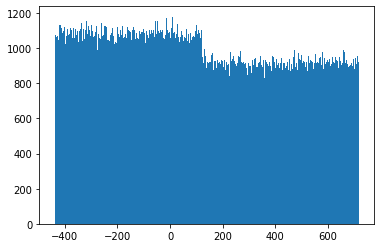

In [9]:
samples = quantized_dist.sample(sample_shape=(1000000,))
plt.hist(samples, bins=1000)
plt.show()

In [10]:
quantized_dist.cdf(0.0)
#quantized_dist.quantile(0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.41137844>

In [11]:
def sampled_median(X, bin_edges, model):
  probabilities = model(X)
  batched_bin_edges = np.broadcast_to(bin_edges, (X.shape[0], N_BINS + 1))
  quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=probabilities),
    components_distribution=tfp.distributions.Uniform(low=batched_bin_edges[:, :-1], high=batched_bin_edges[:, 1:])
  )

  return np.median(quantized_dist.sample(sample_shape=10000000).numpy(), axis=0)


sampled_median(X_test, bin_edges, model)

array([  94.520966,  153.60712 , -102.60416 ], dtype=float32)

In [12]:
def analytic_median(X, bin_edges, model):
  probabilities = model(X)
  bin_widths = np.diff(bin_edges)
  bin_masses = probabilities * bin_widths
  cum_masses = tf.cumsum(bin_masses, axis=1)
  median_mass = cum_masses[:, -1] / 2
  median_bin = tf.searchsorted(cum_masses, tf.expand_dims(median_mass, 1))
  
  lower_edge = tf.gather_nd(bin_edges, median_bin)
  higher_edge = tf.gather_nd(bin_edges, median_bin + 1)

  cum_mass = tf.gather_nd(cum_masses, median_bin, batch_dims=1)
  prob = tf.gather_nd(probabilities, median_bin, batch_dims=1)

  residual = ((cum_mass - median_mass) / prob)

  return higher_edge - residual

res = analytic_median(X_test, bin_edges, model)
print(res)

tf.Tensor([109.595726 168.94873  -99.380356], shape=(3,), dtype=float32)
